# This files shows different implemntations and version of our code

* to save time, run all cell now, while reading trough code. It will take about 5 min to simulate all variations and save them in gif and plots

## The block below is showing the first implementation without runge kutta method

This allows us to have an initial point to compare future resutls with

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.animation import FuncAnimation, PillowWriter

In here we approximate with finite difference method

Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapz): 1.000000
Final area under the curve (np.sum): 0.930743
Final area under the curve (np.trapz): 0.921952


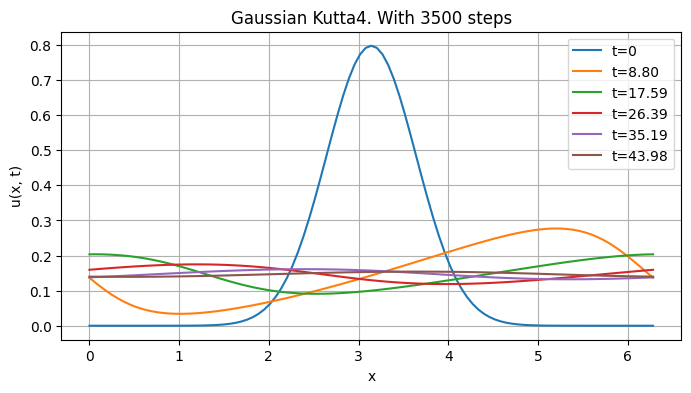

In [37]:
# define parameters
nx = 101         # number of spatial points
L = 2.0 * np.pi  # length of the domain
dx = L / (nx - 1)  # spatial step size
x = np.linspace(0, L, nx)  # spatial grid

nu = 0.07       # viscosity coefficient

# define initial conditions functions
def initial_condition_sine(x):
    # returns sine wave values for the given grid
    return np.sin(x)

def initial_condition_square_wave(x):
    # returns square wave values for the given grid
    return np.where((x >= np.pi) & (x <= 2 * np.pi), 1.0, 0.0)

def initial_condition_gaussian(x):
    gaussian = np.exp(-0.5 * ((x - np.pi) / 0.5)**2)

    #  area under thecurve using the trapezoidal rule
    area = np.trapezoid(gaussian, x)
    
    # normalized Gaussian by dividing it by its area
    return gaussian / area



# set initial conditions dictionary
initial_conditions = {
    # 'Sine Wave': initial_condition_sine,
    # 'Square Wave': initial_condition_square_wave,
    'Gaussian': initial_condition_gaussian
}

# define time parameters
nt = 3500        # number of time steps
sigma = 0.2      # cfl number for advection
max_u = 1.0      # maximum expected value of u

# compute time step sizes
dt_adv = sigma * dx / max_u  # time step for advection
dt_diff = dx**2 / (2 * nu)   # time step for diffusion
dt = min(dt_adv, dt_diff)    # choose the smaller time step for stability

# define burgers' equation update function
def update_burgers(u, dt, dx, nu):
    # performs one time step of burgers' equation update
    un = u.copy()  # create a copy of the current state
    # update the internal points
    u[1:-1] = un[1:-1] - dt * un[1:-1] * (un[1:-1] - un[0:-2]) / dx + \
              nu * dt * (un[2:] - 2 * un[1:-1] + un[0:-2]) / dx**2
    # update the first point using periodic boundary conditions
    u[0] = un[0] - dt * un[0] * (un[0] - un[-2]) / dx + \
           nu * dt * (un[1] - 2 * un[0] + un[-2]) / dx**2
    u[-1] = u[0]  # enforce periodic boundary at the last point
    return u

# define a function to calculate and print area under the curve
def calculate_and_print_area(u, x, label):
    # calculates area using three methods and prints results
    sum_area = np.sum(u) * (x[1] - x[0])  # area using summation
    trapz_area = np.trapezoid(u, x)  # area using trapezoidal rule

    # print the calculated areas with the provided label
    print(f"{label} area under the curve (np.sum): {sum_area:.6f}")
    print(f"{label} area under the curve (np.trapz): {trapz_area:.6f}")

# begin simulation
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)  # get the initial condition
    u = u0.copy()  # create a copy to simulate
    
    # calculate and print the initial area
    calculate_and_print_area(u, x, "Initial")

    # plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} Kutta4. With {nt} steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # start time-stepping simulation
    for n in range(1, nt + 1):
        u = update_burgers(u, dt, dx, nu)  # update solution
        # stop the simulation if values exceed 3 (optional condition)
        if n > 1 and np.any(u >= 3):
            print(f"Stopping at iteration {n}, time t={n * dt:.2f}")
            break

        # plot intermediate steps for visualization
        if n % (nt / 5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")

    # calculate and print the final area
    calculate_and_print_area(u, x, "Final")
    
    # finalize and display the plot
    plt.legend()
    plt.grid(True)
    plt.show()

## At this block we introduce new methods: 
- runge kutta 
- spacial derivative 
- right hand side of Burgers


I will define them in separate block, so that they can be used later without need to repeat them in code

In [38]:
# define function to compute spatial derivatives
def spatial_derivatives(u, dx, nu):
    # computes first and second spatial derivatives with periodic boundaries
    dudx = np.zeros_like(u)
    d2udx2 = np.zeros_like(u)

    dudx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)
    dudx[0] = (u[1] - u[-2]) / (2 * dx)  # periodic left boundary
    dudx[-1] = dudx[0]                   # periodic right boundary

    d2udx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2)
    d2udx2[0] = (u[1] - 2 * u[0] + u[-2]) / (dx**2)  # periodic left boundary
    d2udx2[-1] = d2udx2[0]                          # periodic right boundary

    return dudx, d2udx2

# define function to compute the rhs of Burgers' equation
def rhs_burgers(u, dx, nu):
    # computes the right-hand side of burgers' equation
    dudx, d2udx2 = spatial_derivatives(u, dx, nu)
    return -u * dudx + nu * d2udx2

# define rk4 step method
def rk4_step(u, dt, dx, nu):
    # performs one rk4 time integration step
    k1 = rhs_burgers(u, dx, nu)
    k2 = rhs_burgers(u + 0.5 * dt * k1, dx, nu)
    k3 = rhs_burgers(u + 0.5 * dt * k2, dx, nu)
    k4 = rhs_burgers(u + dt * k3, dx, nu)

    return u + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

The main loop:

Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapz): 1.000000
Final area under the curve (np.sum): 1.009693
Final area under the curve (np.trapz): 1.000000


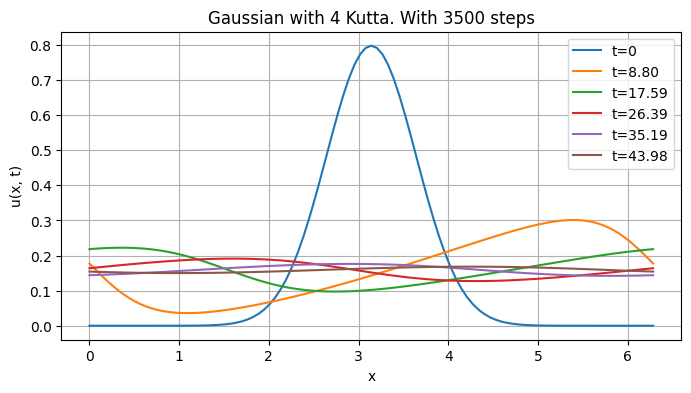

In [39]:
# We keep parameters the same as in previous simulations

# but we define time parameters
nt = 3500        # number of time steps
sigma = 0.2      # cfl number for advection
max_u = 1.0      # maximum expected value of u

# compute time step sizes
dt_adv = sigma * dx / max_u  # time step for advection
dt_diff = dx**2 / (2 * nu)   # time step for diffusion
dt = min(dt_adv, dt_diff)    # choose the smaller time step for stability

# simulation loop
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)  # compute initial condition
    u = u0.copy()    # initialize solution

    # calculate and print initial area
    calculate_and_print_area(u, x, "Initial")

    # plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} with 4 Kutta. With {nt} steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an rk4 step
        u = rk4_step(u, dt, dx, nu)

        # plot 5 time steps of the solution progress
        if n % (nt / 5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")

    # calculate and print final area
    calculate_and_print_area(u, x, "Final")

    # finalize and display plot
    plt.legend()
    plt.grid(True)
    plt.show()

Here we can see that becuase we use Kutta insted of just fininte element approx. We get a better results in terms of Error in the end of the simulation. Which make sense and was expected

# Below is just animated code. Amination is attached in the discord

In [40]:
# method to animate code for easier observation of the values change
def create_animation(x, u_hist, name):
    fig, ax = plt.subplots()
    line, = ax.plot(x, u_hist[0], label='u(x,t)')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_title(f'Guassian with 4kutta. With {nt} steps')
    ax.grid(True)

    def animate(i):
        line.set_ydata(u_hist[i])
        return line,

    ani = FuncAnimation(fig, animate, frames=len(u_hist), interval=10, blit=True)

    filename = f"{name.replace(' ', '_')}_Burgers_Equation.gif"
    ani.save(filename, writer=PillowWriter(fps=30))
    print(f"Saved animation: {filename}")

Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapz): 1.000000
Final area under the curve (np.sum): 1.003245
Final area under the curve (np.trapz): 1.000000
Saved animation: Gaussian_with_Kutta_500_Steps_Burgers_Equation.gif


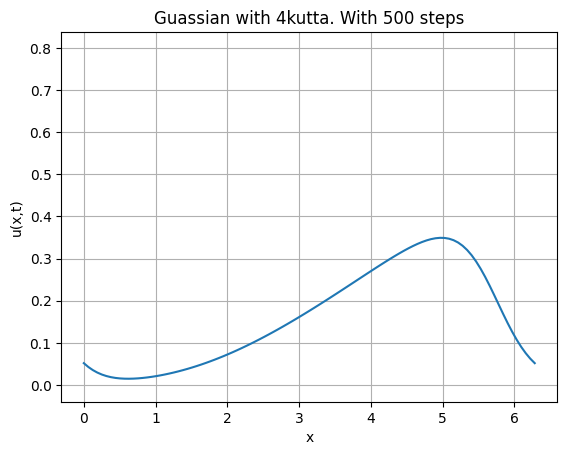

In [41]:
nt = 500 # number of time steps decreased to save animation time, approx: 0.75 min
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()
    
    calculate_and_print_area(u, x, "Initial")

    u_hist = [u.copy()]

    for n in range(1, nt + 1):
        u = rk4_step(u, dt, dx, nu)

        u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    # create and save animation
    create_animation(x, u_hist, f"{name} with Kutta {nt} Steps")

## In this section we will introduce noise to the system

To do so, we need to make sure those values will not ruin the system itself, --> will not go over the defined boudaries

In [42]:
def try_find_index_for_noise(u, candidates, noise_val, lower_bound=0.0, upper_bound=1.0, max_tries=20):
    """
    This method helps find a suitable index in given {u} where 'noise_val' can be applied
    so that we still will keep the values within lowerand upper bounds. Else, we just don't apply this noise
    Later this function is also used for impulse noise verification.

    Returns:
        - chosen_index if found
        - None if not found
    """
    cand_copy = candidates.copy()
    for _ in range(max_tries):
        if len(cand_copy) == 0:
            break
        idx = np.random.choice(cand_copy)
        if lower_bound <= u[idx] + noise_val <= upper_bound:
            return idx
        else:
            # Not suitable, remove this candidate and try another
            cand_copy = cand_copy[cand_copy != idx]

    return None


In [43]:
def add_guassian_noise(u, noise_std=0.005, fraction=0.1, max_tries=20):
    '''
    This function adds guassian noise to the u, with fraction of 10% from all values. Can be changed.
    Also it takes up to n times to find additional point, if one of them have failed.
    '''
    nx = len(u)  # number of spatial points
    num_noise_pairs = int(nx * fraction)  # number of noise pairs to apply-fraction
    
    # Generate Gaussian noise
    noise_values = np.random.normal(loc=0.0, scale=noise_std, size=num_noise_pairs)
    
    # shuffled list of indices for positive and negative noise candidates
    all_indices = np.arange(nx)
    np.random.shuffle(all_indices)
    pos_candidates = all_indices.copy()
    
    np.random.shuffle(all_indices)
    neg_candidates = all_indices.copy()
    
    for noise_val in noise_values:
        # positive noise
        pos_idx = try_find_index_for_noise(
            u=u,
            candidates=pos_candidates,
            noise_val=noise_val,
            lower_bound=0.0,
            upper_bound=1.0,
            max_tries=max_tries
        )
        
        if pos_idx is None:
            # if unable to find a suitable index for positive noise; skip to next noise_val
            continue
        
        # negative noise
        neg_idx = try_find_index_for_noise(
            u=u,
            candidates=neg_candidates,
            noise_val=-noise_val,  # negative noise from positive
            lower_bound=0.0,
            upper_bound=1.0,
            max_tries=max_tries
        )
        
        if neg_idx is None:
            continue
        
        # apply the noise to the selected indexes
        u[pos_idx] += noise_val
        u[neg_idx] -= noise_val
        
        # remove used indesx from candidates -- no repeat
        pos_candidates = pos_candidates[pos_candidates != pos_idx]
        neg_candidates = neg_candidates[neg_candidates != neg_idx]
    
    # periodic boundary
    u[-1] = u[0]
    
    return u


Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapz): 1.000000
Final area under the curve (np.sum): 0.999196
Final area under the curve (np.trapz): 0.996002


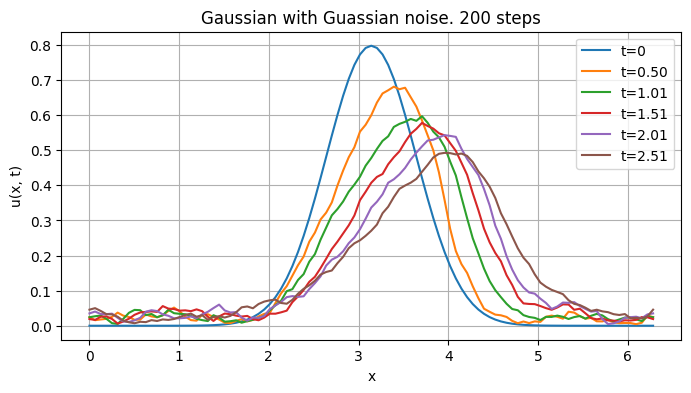

Saved animation: Gaussian_with_Kutta_and_Guassian_noise_200_steps_Burgers_Equation.gif


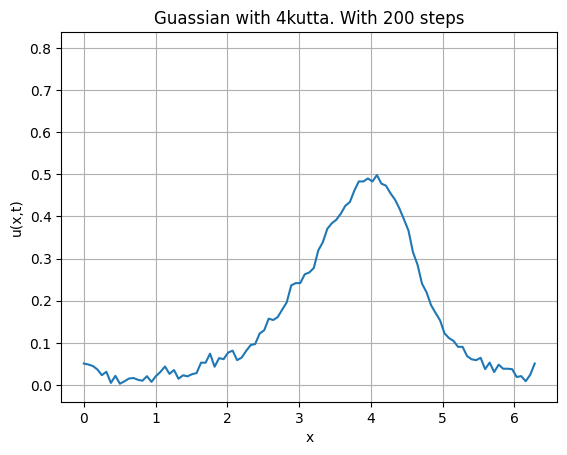

In [44]:
# Time parameters
nt = 200

noise_std = 0.005 # how big is the noise
number_of_steps = 1 # APPLY NOISE EVERY NUMBER OF STEPS. TO PLAY AROUND
fraction = 1 # what % of area will have noise

# main loop for test
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()
    
    calculate_and_print_area(u, x, "Initial")

    u_hist = [u.copy()]

    # plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} with Guassian noise. {nt} steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an rk4 step
        u = rk4_step(u, dt, dx, nu)

        # plot 5 time steps of the solution progress
        if n % (nt / 5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")

        if n % number_of_steps == 0:
            u = add_guassian_noise(u, noise_std, fraction=fraction, max_tries=20)

        u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    plt.legend()
    plt.grid(True)
    plt.show() # Uncomment to show plot, and not only animation

    # create and save animation
    create_animation(x, u_hist, f"{name} with Kutta and Guassian noise {nt} steps")


## Impulse noinse

In [45]:
def add_impulse_noise(u, max_tries=20, neighbors=1):
    """
    Adds an impulse noise: equal to half (or 1.25) of the maximum value in u.
    Balances this addition with a negative impulse also at random palce.

    Furthre can be edited so that we add noinse to the neighbor index, to make it more logical:
        One car speeds up and creates space between car before: lower density
    """

    fraction_of_max_u = 1.25  # fraction used to determine the magnitude of impulses
    u_max = np.max(u)
    noise_val = u_max / fraction_of_max_u  # calculate the value for the impulse based on max(u)

    nx = len(u)  # get the number of spatial points
    all_indices = np.arange(nx)  # create an array of all spatial indices

    # find a suitable index for the positive impulse
    pos_idx = try_find_index_for_noise(
        u=u,
        candidates=all_indices,
        noise_val=noise_val,      # attempt to add noise_val
        lower_bound=0.0,
        upper_bound=1.0,
        max_tries=max_tries
    )

    if pos_idx is None:
        # if no suitable index is found for the positive impulse, return unchanged array
        print("Failed to find a suitable index for positive impulse.")
        return u

    # find a suitable index for the negative impulse
    neg_idx = try_find_index_for_noise(
        u=u,
        candidates=all_indices,
        noise_val=-noise_val,     # attempt to add neg noise_val
        lower_bound=0.0,
        upper_bound=1.0,
        max_tries=max_tries
    )

    if neg_idx is None:
        # if no suitable index is found for the negative impulse, return unchanged array
        print("Failed to find a suitable index for negative impulse.")
        return u

    # looking for neighbor indexes. 
    # we do so to show that once one car (not really but for simplisity...) is slowing down, or speading, the neighbors around it, will do so to
    
    # apply the impulses for neighbors around on both sides
    for i in range(-neighbors, neighbors + 1):
        idx = (pos_idx + i) % nx  # wrap around for periodic boundary
        u[idx] += noise_val

    # negative impulse
    for i in range(-neighbors, neighbors + 1):
        idx = (neg_idx + i) % nx
        u[idx] -= noise_val

    # periodic boundary conditions
    u[-1] = u[0]

    # uncomment below for debugging to verify the changes in the array
    # print(f"Added positive impulse at index {pos_idx} and negative impulse at index {neg_idx}.")
    
    return u

Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapz): 1.000000
Final area under the curve (np.sum): 0.977335
Final area under the curve (np.trapz): 0.973501


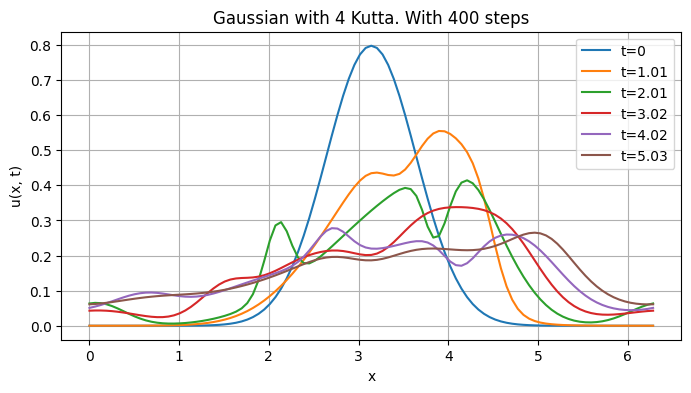

Saved animation: Gaussian_with_Impulse_noise_With_400_steps_Burgers_Equation.gif


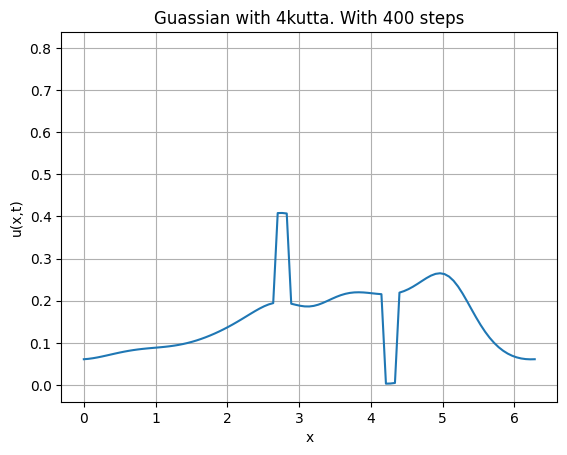

In [46]:
# Time parameters
nt = 400        # Number of time steps

neighbors = 1 #how many indexes around the guessed position will be selected for impulse noise

for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()

    calculate_and_print_area(u, x, "Initial")

    u_hist = [u.copy()]

    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} with 4 Kutta. With {nt} steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an rk4 step
        u = rk4_step(u, dt, dx, nu)

        # plot 5 time steps of the solution progress
        if n % (nt / 5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")
  
        # Every 50 steps, add an impulse noise
        if n % 50 == 0:
            u = add_impulse_noise(u, max_tries=100, neighbors=neighbors)
        u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    plt.legend()
    plt.grid(True)
    plt.show()

    create_animation(x, u_hist, f'{name} with Impulse noise With {nt} steps')

### New initial conditions as a flat line from 1 to 3

In [47]:
def initial_condition_flat(x):
    # flat region of 0.5 from x=1 to x=3 and 0 elsewhere
    u = np.zeros_like(x)
    mask = (x >= 1.0) & (x <= 3.0)
    u[mask] = 0.5
    return u

initial_conditions = {
    # f'Gaussian with Kutta4 with {nt} steps': initial_condition_gaussian,
    f'Flat Line': initial_condition_flat
}

Initial area under the curve (np.sum): 1.005310
Initial area under the curve (np.trapz): 1.005310
Final area under the curve (np.sum): 1.010049
Final area under the curve (np.trapz): 1.005310


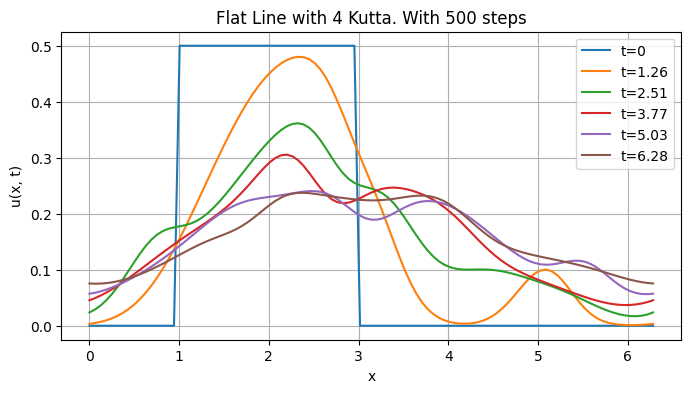

Saved animation: Flat_Line_with_Impulse_noise_500_steps_Burgers_Equation.gif


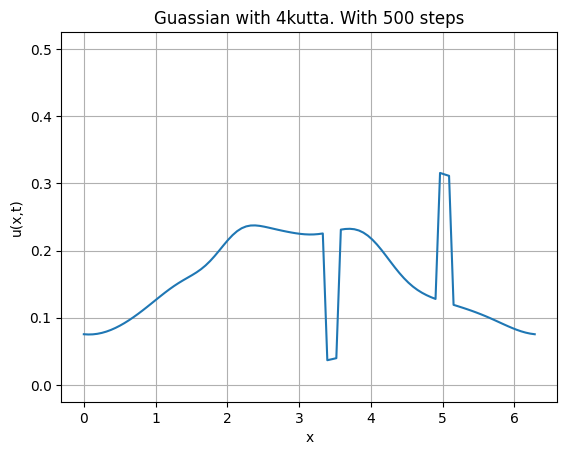

In [48]:
nt = 500

neighbors = 1

for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()

    calculate_and_print_area(u, x, "Initial")

    u_hist = [u.copy()]

    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} with 4 Kutta. With {nt} steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an rk4 step
        u = rk4_step(u, dt, dx, nu)

        # plot 5 time steps of the solution progress
        if n % (nt / 5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")
  
        # Every 50 steps, add an impulse noise
        if n % 50 == 0:
            u = add_impulse_noise(u, max_tries=100, neighbors=neighbors)
        u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    plt.legend()
    plt.grid(True)
    plt.show()

    create_animation(x, u_hist, f'{name} with Impulse noise {nt} steps')


# Traffic Stop

Its still mostly a test area. The code below is based on a few articles and guides.. bit i am not sure if it was applied correcly. 
Generally about reflcetive boudary conditions and its usage in wave propagation

Initial conditions: Gaussian
Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapz): 1.000000
Final area under the curve (np.sum): 0.856574
Final area under the curve (np.trapz): 0.854025


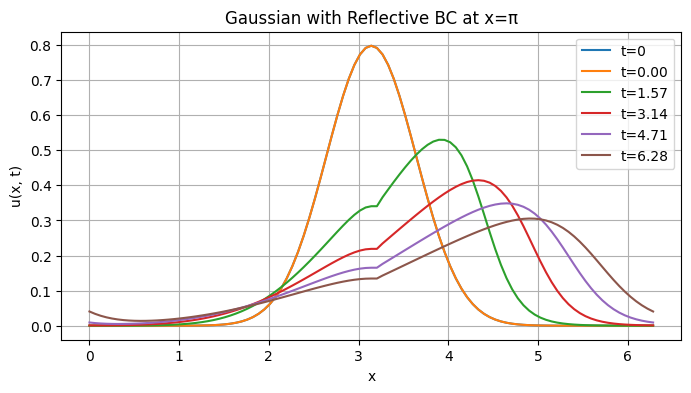

Saved animation: Gaussian_with_Reflective_BC_and_500_steps.gif


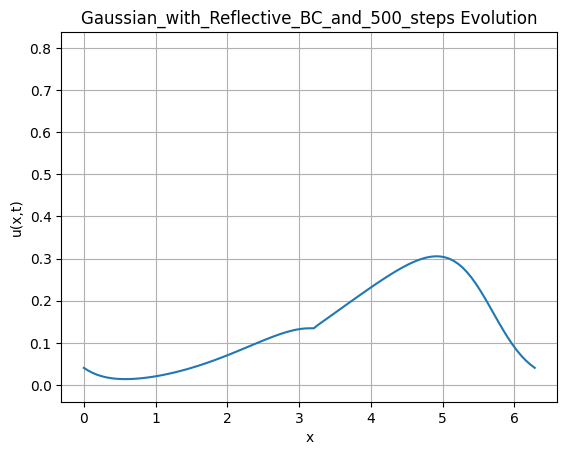

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.integrate import simpson

nx = 101         # spatial points
L = 2.0 * np.pi  # domain length
dx = L / (nx - 1)
x = np.linspace(0, L, nx)
nu = 0.07        # viscosity

# midpoint (red light) index
i_mid = nx // 2  # x[i_mid] ~ pi

# timw param
nt = 500
sigma = 0.2
max_u = 1.0

dt_adv = sigma * dx / max_u
dt_diff = dx**2 / (2 * nu)
dt = min(dt_adv, dt_diff)


def initial_condition_gaussian(x):
    gaussian = np.exp(-0.5 * ((x - np.pi) / 0.5)**2)

    #  area under thecurve using the trapezoidal rule
    area = np.trapezoid(gaussian, x)
    
    # normalized Gaussian by dividing it by its area
    return gaussian / area


# set initial conditions dictionary
initial_conditions = {
    'Gaussian': initial_condition_gaussian
}

# a bit spatial derivatives to handle no-flux boundary at i_mid
def spatial_derivatives(u, dx, nu, i_mid):
    dudx = np.zeros_like(u)
    d2udx2 = np.zeros_like(u)

    # periodic boundary
    dudx[0] = (u[1] - u[-2]) / (2 * dx)
    dudx[-1] = dudx[0]
    d2udx2[0] = (u[1] - 2*u[0] + u[-2]) / (dx**2)
    d2udx2[-1] = d2udx2[0]

    # left side: 1 to i_mid-1
    for i in range(1, i_mid):
        dudx[i] = (u[i+1] - u[i-1])/(2*dx)
        d2udx2[i] = (u[i+1] - 2*u[i] + u[i-1])/(dx**2)

    # No-flux boundary at i_mid
    # zero slope here:
    dudx[i_mid] = 0.0
    
    # THE BELOW part is adjusted by GPTo1: so i can't fully get all reasoning behind it yet and how is that correct

    # For second derivative, use a one-sided approximation or set to zero:
    # Here we assume symmetric: use u[i_mid-1] twice (mirror)
    d2udx2[i_mid] = (u[i_mid-1] - 2*u[i_mid] + u[i_mid-1])/(dx**2)

    # riht side: i_mid+1 to nx-2
    for i in range(i_mid+1, nx-1):
        dudx[i] = (u[i+1] - u[i-1])/(2*dx)
        d2udx2[i] = (u[i+1] - 2*u[i] + u[i-1])/(dx**2)

    return dudx, d2udx2

def rhs_burgers(u, dx, nu, i_mid):
    dudx, d2udx2 = spatial_derivatives(u, dx, nu, i_mid)
    return -u * dudx + nu * d2udx2

def rk4_step(u, dt, dx, nu, i_mid):
    k1 = rhs_burgers(u, dx, nu, i_mid)
    k2 = rhs_burgers(u + 0.5 * dt * k1, dx, nu, i_mid)
    k3 = rhs_burgers(u + 0.5 * dt * k2, dx, nu, i_mid)
    k4 = rhs_burgers(u + dt * k3, dx, nu, i_mid)
    u_new = u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return u_new

# Enforce no-flux boundary after each time step
def enforce_reflective_boundary(u, i_mid):
    # Make sure there's no jump at x=pi
    u[i_mid+1] = u[i_mid]



# Visualization and simulation
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()

    print(f"Initial conditions: {name}")
    calculate_and_print_area(u, x, "Initial")

    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} with Reflective BC at x=π')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    snapshot_times = [0.0, nt*dt/4, nt*dt/2, 3*nt*dt/4, nt*dt]
    snapshots = {0.0: u.copy()}

    for n in range(1, nt+1):
        u = rk4_step(u, dt, dx, nu, i_mid)
        enforce_reflective_boundary(u, i_mid)

        current_time = n * dt
        if any(abs(current_time - st) < 1e-12 for st in snapshot_times):
            snapshots[current_time] = u.copy()

    calculate_and_print_area(u, x, "Final")

    # Plot snapshots
    for t, u_snap in snapshots.items():
        plt.plot(x, u_snap, label=f"t={t:.2f}")

    plt.legend()
    plt.grid(True)
    plt.show()

# Optional animation
def create_animation(x, u_hist, name):
    fig, ax = plt.subplots()
    line, = ax.plot(x, u_hist[0], label='u(x,t)')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_title(f'{name} Evolution')
    ax.grid(True)

    def animate(i):
        line.set_ydata(u_hist[i])
        return (line,)

    ani = FuncAnimation(fig, animate, frames=len(u_hist), interval=10, blit=True)
    filename = f"{name.replace(' ', '_')}.gif"
    ani.save(filename, writer=PillowWriter(fps=30))
    print(f"Saved animation: {filename}")

# Example animation for the Gaussian initial condition
name = 'Gaussian'
u0 = initial_conditions[name](x)
u = u0.copy()
u_hist = [u.copy()]

for n in range(1, nt+1):
    u = rk4_step(u, dt, dx, nu, i_mid)
    enforce_reflective_boundary(u, i_mid)
    u_hist.append(u.copy())

create_animation(x, u_hist, f"{name}_with_Reflective_BC_and_{nt}_steps")


In [52]:
#----------------------------------------RESETTING OLD CODE, SCROL----------------------------------------#

# define function to compute spatial derivatives
def spatial_derivatives(u, dx, nu):
    # computes first and second spatial derivatives with periodic boundaries
    dudx = np.zeros_like(u)
    d2udx2 = np.zeros_like(u)

    dudx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)
    dudx[0] = (u[1] - u[-2]) / (2 * dx)  # periodic left boundary
    dudx[-1] = dudx[0]                   # periodic right boundary

    d2udx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2)
    d2udx2[0] = (u[1] - 2 * u[0] + u[-2]) / (dx**2)  # periodic left boundary
    d2udx2[-1] = d2udx2[0]                          # periodic right boundary

    return dudx, d2udx2

# define function to compute the rhs of Burgers' equation
def rhs_burgers(u, dx, nu):
    # computes the right-hand side of burgers' equation
    dudx, d2udx2 = spatial_derivatives(u, dx, nu)
    return -u * dudx + nu * d2udx2

# define rk4 step method
def rk4_step(u, dt, dx, nu):
    # performs one rk4 time integration step
    k1 = rhs_burgers(u, dx, nu)
    k2 = rhs_burgers(u + 0.5 * dt * k1, dx, nu)
    k3 = rhs_burgers(u + 0.5 * dt * k2, dx, nu)
    k4 = rhs_burgers(u + dt * k3, dx, nu)

    return u + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

#----------------------------------------NEW CODE BELOW----------------------------------------#

nt = 1300

def initial_condition_gaussian(x):
    gaussian = np.exp(-0.5 * ((x - np.pi) / 0.5)**2)

    #  area under thecurve using the trapezoidal rule
    area = np.trapezoid(gaussian, x)
    
    # normalized Gaussian by dividing it by its area
    return gaussian / area


# red light (basically zero velocity in a specified region)
def apply_red_light(u, x, x_red_start, x_red_end, max_u=max_u):
    u[np.logical_and(x >= x_red_start, x <= x_red_end)] = max_u
    return u

# redlight zone
x_red_start, x_red_end = np.pi, np.pi + 0.5  # Red light zone

# Initial condition
u = initial_condition_gaussian(x)

# Time evolution
u_hist = [u.copy()]

for n in range(1, nt + 1):
    u = rk4_step(u, dt, dx, nu)

    if n >= 300:
        u = apply_red_light(u, x, x_red_start, x_red_end)  # Apply red light condition
        
    if n % 10 == 0:
        u_hist.append(u.copy())

# # Plot results
# plt.figure(figsize=(10, 6))
# for i, u_snapshot in enumerate(u_hist):
#     plt.plot(x, u_snapshot, label=f"t={i * 10 * dt:.2f}")
# plt.axvspan(x_red_start, x_red_end, color='red', alpha=0.3, label="Red Light Zone")
# plt.title("Gaussian Wave Evolution with Red Light")
# plt.xlabel("x")
# plt.ylabel("u(x, t)")
# plt.legend()
# plt.grid(True)
# plt.show()


In [53]:
import matplotlib.animation as animation

# Create animation
fig, ax = plt.subplots()
line, = ax.plot(x, u_hist[0], label="u(x, t)")
ax.axvspan(x_red_start, x_red_end, color='red', alpha=0.3, label="Red Light Zone")
ax.set_xlabel("x")
ax.set_ylabel("u(x, t)")
ax.set_title("Gaussian Wave Evolution with Red Light")
ax.legend()
ax.grid(True)
ax.set_ylim(0, 1.1)  # Set consistent y-limits for clarity

def animate(i):
    line.set_ydata(u_hist[i])
    return line,

ani = animation.FuncAnimation(fig, animate, frames=len(u_hist), interval=100, blit=True)

# Save the animation
from matplotlib.animation import PillowWriter

filename = "gaussian_wave_red_light.gif"
ani.save(filename, writer=PillowWriter(fps=30))
plt.close(fig)

filename


'gaussian_wave_red_light.gif'